In [1]:
from qiskit.circuit.library import QAOAAnsatz

import parity_network
import importlib
import numpy as np

#### This one is for a mix of 4-sat and 5-sat with 8 qubits.
#### The clauses are : (x₀ ∨ ¬x₂ ∨ x₃ ∨ ¬x₅ ∨ x₇) ^ (¬x₀ ∨ x₁ ∨ ¬x₄ ∨ x₆) ^ (x₁ ∨ x₂ ∨ ¬x₃ ∨ x₆ ∨ ¬x₇) ^ (x₀ ∨ ¬x₄ ∨ x₅ ∨ ¬x₆) ^ (¬x₁ ∨ ¬x₂ ∨ x₄ ∨ x₅ ∨ x₇)

In [23]:
num_qubits = 8

In [ ]:
from qiskit import QuantumCircuit


def cnot_count(circuit: QuantumCircuit) -> int:
    return circuit.count_ops().get("cx", 0)

In [25]:
importlib.reload(parity_network)

parity, term_dict = parity_network.main(num_qubits)

parity_ansatz = QAOAAnsatz(parity, reps=10)
parity_ansatz.measure_all()

# parity_ansatz.decompose().draw("mpl")

Parities and Weights of the Hamiltonian:
{'00000000': 0.2188, '10000000': 0.0312, '01000000': 0.0625, '00100000': -0.0312, '00001000': -0.0938, '00000100': 0.0625, '00000010': 0.0312, '00000001': 0.0312, '11000000': -0.0625, '10100000': -0.0312, '10010000': 0.0312, '10000100': 0.0312, '10000010': -0.125, '10000001': 0.0312, '01100000': 0.0625, '01010000': -0.0312, '01001000': -0.0938, '01000100': -0.0312, '01000010': 0.0938, '01000001': -0.0625, '00110000': -0.0625, '00101000': -0.0312, '00100010': 0.0312, '00100001': -0.0938, '00010100': -0.0312, '00010010': -0.0312, '00010001': 0.0625, '00001100': -0.0312, '00001001': 0.0312, '00000110': -0.0625, '00000011': -0.0312, '11001000': 0.0625, '11000010': -0.0625, '10110000': -0.0312, '10100100': 0.0312, '10100001': -0.0312, '10010100': -0.0312, '10010001': 0.0312, '10001100': -0.0625, '10001010': 0.125, '10000110': -0.0625, '10000101': -0.0312, '01110000': -0.0312, '01101000': 0.0312, '01100100': 0.0312, '01100010': 0.0312, '01010010': -0.

In [5]:
from qiskit.quantum_info import SparsePauliOp


def get_hamiltonian_observable(term_dict, n_qubits):
    """Converts a dictionary of bitstrings and weights into a Qiskit SparsePauliOp observable."""
    pauli_list = []
    coeff_list = []
    for bitstring, weight in term_dict.items():
        pauli_str = ["I"] * n_qubits
        for i, bit in enumerate(bitstring):
            if bit == "1":
                pauli_str[n_qubits - 1 - i] = "Z"
        pauli_list.append("".join(pauli_str))
        coeff_list.append(weight)

    return SparsePauliOp(pauli_list, coeffs=coeff_list)

In [26]:
from scipy.optimize import minimize
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import EstimatorV2 as AerEstimator
from qiskit.compiler import transpile

backend = AerSimulator()
estimator = AerEstimator()
estimator.options.shots = 10000

parity_ansatz_isa = transpile(parity_ansatz, backend=backend)

obs = get_hamiltonian_observable(term_dict, num_qubits)
print(obs)
print("CNOT count :", cnot_count(parity_ansatz_isa))

SparsePauliOp(['IIIIIIII', 'IIIIIIIZ', 'IIIIIIZI', 'IIIIIZII', 'IIIZIIII', 'IIZIIIII', 'IZIIIIII', 'ZIIIIIII', 'IIIIIIZZ', 'IIIIIZIZ', 'IIIIZIIZ', 'IIZIIIIZ', 'IZIIIIIZ', 'ZIIIIIIZ', 'IIIIIZZI', 'IIIIZIZI', 'IIIZIIZI', 'IIZIIIZI', 'IZIIIIZI', 'ZIIIIIZI', 'IIIIZZII', 'IIIZIZII', 'IZIIIZII', 'ZIIIIZII', 'IIZIZIII', 'IZIIZIII', 'ZIIIZIII', 'IIZZIIII', 'ZIIZIIII', 'IZZIIIII', 'ZZIIIIII', 'IIIZIIZZ', 'IZIIIIZZ', 'IIIIZZIZ', 'IIZIIZIZ', 'ZIIIIZIZ', 'IIZIZIIZ', 'ZIIIZIIZ', 'IIZZIIIZ', 'IZIZIIIZ', 'IZZIIIIZ', 'ZIZIIIIZ', 'IIIIZZZI', 'IIIZIZZI', 'IIZIIZZI', 'IZIIIZZI', 'IZIIZIZI', 'ZIIIZIZI', 'IIZZIIZI', 'IZIZIIZI', 'ZIIZIIZI', 'ZIZIIIZI', 'ZZIIIIZI', 'IIZIZZII', 'IZIIZZII', 'IIZZIZII', 'ZIIZIZII', 'ZZIIIZII', 'ZIZIZIII', 'ZZIIZIII', 'IZZZIIII', 'ZIZZIIII', 'IZIZIIZZ', 'IIZIZZIZ', 'ZIIIZZIZ', 'ZIZIIZIZ', 'ZIZIZIIZ', 'IZZZIIIZ', 'IZIIZZZI', 'ZIIIZZZI', 'IIZZIZZI', 'ZIIZIZZI', 'ZIZIIZZI', 'ZZIIIZZI', 'ZZIIZIZI', 'ZIZZIIZI', 'ZIZIZZII', 'ZZIIZZII', 'ZIZZIZII', 'ZIZIZZIZ', 'ZZIIZZZI', 'ZIZZIZZI'],


In [7]:
parity_cost_history_dict = {
    "iters": 0,
    "cost_history": [],
}


def initialize_cost_history_dict(cost_history_dict):
    cost_history_dict["iters"] = 0
    cost_history_dict["cost_history"] = []

In [8]:
def cost_func_estimator(params, ansatz, hamiltonian, estimator, cost_history_dict):

    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)

    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])

    results = job.result()[0]
    cost = results.data.evs

    cost_history_dict["iters"] += 1
    cost_history_dict["cost_history"].append(cost)
    print(f"Iters {cost_history_dict['iters']}: Current cost: {cost}")

    return cost

In [27]:
params_init = np.random.rand(parity_ansatz_isa.num_parameters) * 2 * np.pi
initialize_cost_history_dict(parity_cost_history_dict)

result_parity = minimize(
    cost_func_estimator,
    params_init,
    args=(parity_ansatz_isa, obs, estimator, parity_cost_history_dict),
    method="COBYLA",
)

Iters 1: Current cost: 0.2948447265624999
Iters 2: Current cost: 0.42081230468749986
Iters 3: Current cost: 0.4198072265625001
Iters 4: Current cost: 0.3807726562500001
Iters 5: Current cost: 0.41313125
Iters 6: Current cost: 0.47551718750000005
Iters 7: Current cost: 0.4433037109375
Iters 8: Current cost: 0.5517724609375001
Iters 9: Current cost: 0.6103869140625001
Iters 10: Current cost: 0.4912011718750002
Iters 11: Current cost: 0.41801679687500004
Iters 12: Current cost: 0.3602648437500001
Iters 13: Current cost: 0.3309109375000001
Iters 14: Current cost: 0.31737246093749993
Iters 15: Current cost: 0.2500080078125
Iters 16: Current cost: 0.25387324218749996
Iters 17: Current cost: 0.35836035156249985
Iters 18: Current cost: 0.3261597656249999
Iters 19: Current cost: 0.14364687500000003
Iters 20: Current cost: 0.15729902343750007
Iters 21: Current cost: 0.23539082031249992
Iters 22: Current cost: 0.30474179687499997
Iters 23: Current cost: 0.2685375
Iters 24: Current cost: 0.1670816

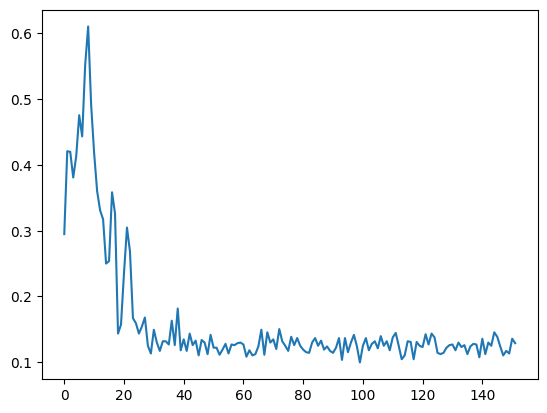

In [28]:
import matplotlib.pyplot as plt

plt.plot(parity_cost_history_dict["cost_history"])

In [29]:
naive_ansatz = QAOAAnsatz(obs, reps=10)
naive_ansatz.measure_all()

# naive_ansatz.decompose().draw("mpl")

In [30]:
naive_ansatz_isa = transpile(naive_ansatz, backend=backend)

print("CNOT count :", cnot_count(naive_ansatz_isa))

CNOT count : 2260


In [31]:
naive_cost_history_dict = {
    "iters": 0,
    "cost_history": [],
}

In [32]:
params_init = np.random.rand(naive_ansatz_isa.num_parameters) * 2 * np.pi
initialize_cost_history_dict(naive_cost_history_dict)

result_naive = minimize(
    cost_func_estimator,
    params_init,
    args=(naive_ansatz_isa, obs, estimator, naive_cost_history_dict),
    method="COBYLA",
)

Iters 1: Current cost: 0.20516542968749985
Iters 2: Current cost: 0.3262142578125002
Iters 3: Current cost: 0.34471738281250003
Iters 4: Current cost: 0.2803796875
Iters 5: Current cost: 0.2969656250000001
Iters 6: Current cost: 0.476483203125
Iters 7: Current cost: 0.37982500000000013
Iters 8: Current cost: 0.38277753906249984
Iters 9: Current cost: 0.38569941406249997
Iters 10: Current cost: 0.22957890625000008
Iters 11: Current cost: 0.26570468749999987
Iters 12: Current cost: 0.22665429687500002
Iters 13: Current cost: 0.18761640625
Iters 14: Current cost: 0.1612613281249999
Iters 15: Current cost: 0.3291205078124999
Iters 16: Current cost: 0.16616992187499988
Iters 17: Current cost: 0.23349609374999997
Iters 18: Current cost: 0.17396367187499998
Iters 19: Current cost: 0.21882031250000006
Iters 20: Current cost: 0.275430078125
Iters 21: Current cost: 0.1758986328125
Iters 22: Current cost: 0.6473585937499995
Iters 23: Current cost: 0.31161660156250004
Iters 24: Current cost: 0.172

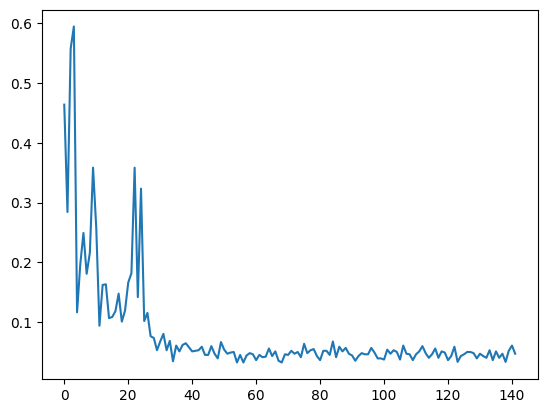

In [15]:
plt.plot(naive_cost_history_dict["cost_history"])

### Sampler

In [38]:
optimized_parity_ansatz = parity_ansatz_isa.assign_parameters(result_parity.x)

In [ ]:
from qiskit_aer.primitives import SamplerV2 as AerSampler

sampler = AerSampler()
sampler.options.shots = 10000

parity_job = sampler.run([optimized_parity_ansatz])
parity_res = parity_job.result()

In [43]:
counts = parity_res[0].data.meas.get_counts()
most_likely_bitstring = max(counts, key=counts.get)

print(f"\nMost likely solution bitstring: {most_likely_bitstring}")


Most likely solution bitstring: 00100111


In [44]:
optimized_naive_ansatz = parity_ansatz_isa.assign_parameters(result_naive.x)

In [45]:
naive_job = sampler.run([optimized_naive_ansatz])
naive_res = naive_job.result()

counts = naive_res[0].data.meas.get_counts()
most_likely_bitstring = max(counts, key=counts.get)

print(f"\nMost likely solution bitstring: {most_likely_bitstring}")


Most likely solution bitstring: 11110000


### Only the parity synthesis one is the correct answer.

## Noise AerSimulator

In [33]:
from qiskit_aer.noise import NoiseModel, depolarizing_error

noise_model = NoiseModel()
cx_depolarizing_prob = 0.02
noise_model.add_all_qubit_quantum_error(
    depolarizing_error(cx_depolarizing_prob, 2), ["cx"]
)

noisy_estimator = AerEstimator(
    options=dict(backend_options=dict(noise_model=noise_model))
)

In [34]:
noisy_parity_cost_history_dict = {
    "iters": 0,
    "cost_history": [],
}

In [35]:
params_init = np.random.rand(parity_ansatz_isa.num_parameters) * 2 * np.pi
initialize_cost_history_dict(noisy_parity_cost_history_dict)

result_noisy_parity = minimize(
    cost_func_estimator,
    params_init,
    args=(parity_ansatz_isa, obs, noisy_estimator, noisy_parity_cost_history_dict),
    method="COBYLA",
)

Iters 1: Current cost: 0.23148535156250008
Iters 2: Current cost: 0.22661171874999997
Iters 3: Current cost: 0.21682421874999994
Iters 4: Current cost: 0.1963468750000001
Iters 5: Current cost: 0.2129267578125
Iters 6: Current cost: 0.19341738281249996
Iters 7: Current cost: 0.2334400390625
Iters 8: Current cost: 0.20513925781249995
Iters 9: Current cost: 0.20707910156249992
Iters 10: Current cost: 0.23052070312499998
Iters 11: Current cost: 0.22562753906250002
Iters 12: Current cost: 0.2304970703124999
Iters 13: Current cost: 0.23343652343750007
Iters 14: Current cost: 0.21882226562500007
Iters 15: Current cost: 0.21196464843750004
Iters 16: Current cost: 0.21392910156249992
Iters 17: Current cost: 0.22464921875
Iters 18: Current cost: 0.2275697265625
Iters 19: Current cost: 0.19832128906249993
Iters 20: Current cost: 0.23732539062499997
Iters 21: Current cost: 0.23831601562500002
Iters 22: Current cost: 0.1983210937499999
Iters 23: Current cost: 0.2441830078124999
Iters 24: Current c

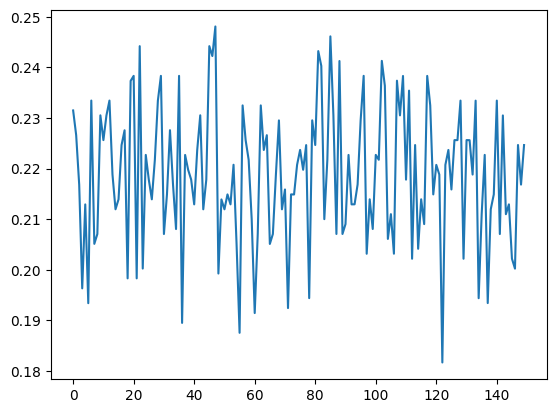

In [36]:
plt.plot(noisy_parity_cost_history_dict["cost_history"])

In [20]:
noisy_naive_cost_history_dict = {
    "iters": 0,
    "cost_history": [],
}

In [37]:
params_init = np.random.rand(naive_ansatz_isa.num_parameters) * 2 * np.pi
initialize_cost_history_dict(noisy_naive_cost_history_dict)

result_naive = minimize(
    cost_func_estimator,
    params_init,
    args=(naive_ansatz_isa, obs, noisy_estimator, noisy_naive_cost_history_dict),
    method="COBYLA",
)

Iters 1: Current cost: 0.2149013671875
Iters 2: Current cost: 0.23148906249999998
Iters 3: Current cost: 0.2178236328125
Iters 4: Current cost: 0.22074746093750003
Iters 5: Current cost: 0.24027890624999995
Iters 6: Current cost: 0.21393359375000007
Iters 7: Current cost: 0.1963480468749999
Iters 8: Current cost: 0.19634531250000004
Iters 9: Current cost: 0.21685175781249996
Iters 10: Current cost: 0.221720703125
Iters 11: Current cost: 0.18463222656249997
Iters 12: Current cost: 0.2197765624999999
Iters 13: Current cost: 0.2197794921875001
Iters 14: Current cost: 0.21394980468750005
Iters 15: Current cost: 0.22756738281249989
Iters 16: Current cost: 0.22270449218749994
Iters 17: Current cost: 0.2119802734375001
Iters 18: Current cost: 0.22759453125000004
Iters 19: Current cost: 0.21391328124999995
Iters 20: Current cost: 0.24516406249999997
Iters 21: Current cost: 0.21100449218749998
Iters 22: Current cost: 0.22761523437499998
Iters 23: Current cost: 0.23246738281249993
Iters 24: Curr

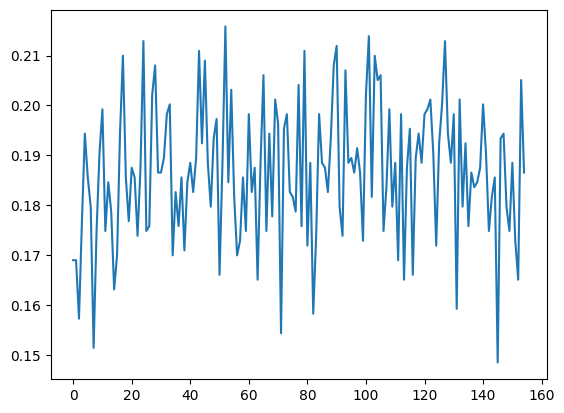

In [22]:
plt.plot(noisy_naive_cost_history_dict["cost_history"])